In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix, f1_score, precision_score, recall_score
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer


/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter
def calculate_accuracy(y_pred, y_true):
    class_weights = {cls: 1.0/count for cls, count in Counter(y_true).items()}
    wa = balanced_accuracy_score(y_true, y_pred, sample_weight=[class_weights[cls] for cls in y_true])
    ua = accuracy_score(y_true, y_pred)
    return wa, ua

In [6]:
def eval(opt, checkpoint_path, tokenizer, all_state_dict=True, v2=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if v2:
        network = getattr(networks, opt.model_type)(opt)
    else:
        network = getattr(networks, opt.model_type)(
                    num_classes=opt.num_classes,
                    num_attention_head=opt.num_attention_head,
                    dropout=opt.dropout,
                    text_encoder_type=opt.text_encoder_type,
                    text_encoder_dim=opt.text_encoder_dim,
                    text_unfreeze=opt.text_unfreeze,
                    audio_encoder_type=opt.audio_encoder_type,
                    audio_encoder_dim=opt.audio_encoder_dim,
                    audio_unfreeze=opt.audio_unfreeze,
                    audio_norm_type=opt.audio_norm_type,
                    fusion_head_output_type=opt.fusion_head_output_type,
                )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    weight = torch.load(checkpoint_path, map_location=torch.device(device))
    if all_state_dict:
        weight = weight['state_dict_network']
    else:
        weight = weight.state_dict()
    
    network.load_state_dict(weight)
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = network(input_ids,audio)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    bacc = balanced_accuracy_score(y_actu, y_pred)
    acc = accuracy_score(y_actu, y_pred)
    print("Balanced Accuracy: ", bacc)
    print("Accuracy: ", acc)
    ua, wa = calculate_accuracy(y_actu, y_pred)
    print("Unweighted Accuracy: ", ua)
    print("Weighted Accuracy: ", wa)
    ua_f1 = f1_score(y_actu, y_pred, average='macro')
    w_f1 = f1_score(y_actu, y_pred, average='weighted')
    f1 = f1_score(y_actu, y_pred, average='micro')
    print("Micro F1: ", f1)
    print("Macro F1: ", ua_f1)
    print("Weighted F1: ", w_f1)
    ua_precision = precision_score(y_actu, y_pred, average='macro')
    w_precision = precision_score(y_actu, y_pred, average='weighted')
    precision = precision_score(y_actu, y_pred, average='micro')
    print("Micro Precision: ", precision)
    print("Macro Precision: ", ua_precision)
    print("Weighted Precision: ", w_precision)
    ua_recall = recall_score(y_actu, y_pred, average='macro')
    w_recall = recall_score(y_actu, y_pred, average='weighted')
    recall = recall_score(y_actu, y_pred, average='micro')
    print("Micro Recall: ", recall)
    print("Macro Recall: ", ua_recall)
    print("Weighted Recall: ", w_recall)
    
    cm = confusion_matrix(y_actu, y_pred)
    print("Confusion Matrix: \n", cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

    ax = plt.subplots(figsize=(8, 5.5))[1]
    sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
    ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
    ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    plt.tight_layout()
    # plt.savefig(opt.name + '.png', format='png', dpi=1200)
    plt.show()

100%|██████████| 933/933 [00:46<00:00, 19.88it/s]


Balanced Accuracy:  0.6669185734196517
Accuracy:  0.6580921757770632
Unweighted Accuracy:  0.6684487681704636
Weighted Accuracy:  0.6580921757770632
Micro F1:  0.6580921757770632
Macro F1:  0.6653382715578704
Weighted F1:  0.6583208102776666
Micro Precision:  0.6580921757770632
Macro Precision:  0.6684487681704636
Weighted Precision:  0.6640027874156225
Micro Recall:  0.6580921757770632
Macro Recall:  0.6669185734196517
Weighted Recall:  0.6580921757770632
Confusion Matrix: 
 [[127  16   5  29]
 [ 33 163  24  61]
 [  4  13 144  43]
 [ 23  41  27 180]]


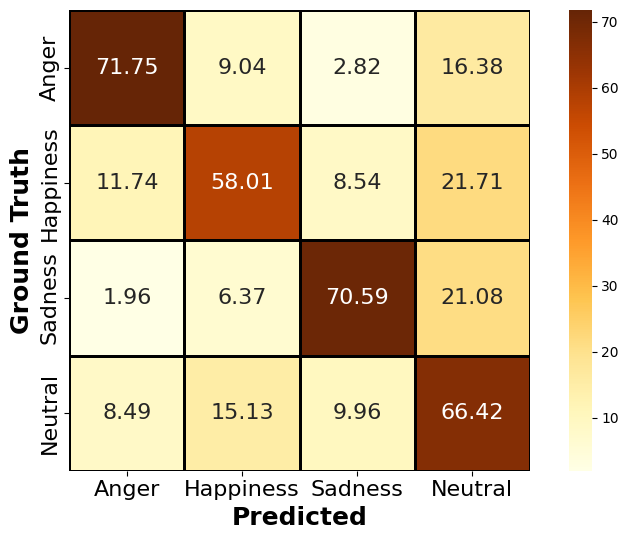

In [7]:
from configs.base import Config
checkpoint_path = "/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/audio_only/audio_wavlm_cel_v2/20230904-093013"
opt_path = os.path.join(checkpoint_path,"opt.log")
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt")
opt = Config()
opt.load(opt_path)
# Set dataset path
opt.data_root="/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/data/IEMOCAP/"

# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
eval(opt, ckpt_path, tokenizer, v2=True)